[한국전력공사\_공동주택 전력·기상 융합데이터\_20221231 | 공공데이터포털](https://www.data.go.kr/data/15120804/fileData.do)

한국전력공사_공동주택 전력·기상 융합데이터
한국전력공사와 기상청이 공동주택 부하관리관련 연구개발 활성화를 목적으로 제공하는 데이터셋입니다.
데이터셋은 기상청 동네예보 격자단위 시간대별 공동주택 전력부하와 기상관측값을 포함하고 있습니다.
공동주택 전력부하는 각 연도별 결측치가 없는 단지에 한하여 합계한 통계값이며, 격자내 공동주택이 10개 이상인 격자에 대해서만 제공하고 있습니다.

[2024 날씨 빅데이터콘테스트 설명동영상(과제4, 전력분야) - YouTube](https://www.youtube.com/watch?v=9xCBKNrymig&t=265s)


---

**| 학습 데이터(전력)**

-   **제공기간** : 2020년, 2021년, 2022년 (총 3개년)
-   **자료설명** : 원격검침이 이루어지는 공동주택 중 각 연도별 결측치가 없는 단지를 대상으로 기상예보 격자별로 산출된 전력 통계값. 격자내 공동주택이 10개 이상인 격자에 대해서만 공개함.

**컬럼 정보**

| 변수명        | 변수 설명      | 항목설명                                                                                                |
| :------------ | :------------- | :------------------------------------------------------------------------------------------------------ |
| TM            | 날짜           | 공동주택 전력부하 측정 날짜(시간포함, 단위(0~23시))                                                          |
| HH24          | 시간           | 공동주택 전력부하 측정 시간(1~24), 5시는 4시 1분~5시 00분까지의 전력부하를 의미                                  |
| weekday       | 요일           | 요일을 숫자형식으로 표시 월요일(0)~일요일(6)                                                                 |
| week\_name    | 주중 주말      | 주중 주말을 숫자형식으로 표시 주중(0), 주말(1)                                                               |
| SUM\_QCTR     | 계약전력합계   | 해당격자의 전력통계 산출에 포함된 공동주택의 계약전력 합계                                                       |
| N             | 공동주택 수    | 해당격자의 전력통계 산출에 포함된 공동주택의 수, 단위(단지)                                                      |
| SUM\_LOAD     | 전력수요 합계  | 해당격자/시각에 측정된 공동주택의 전력수요 합계                                                                |
| N\_MEAN\_LOAD | 전력부하량 평균 | 격자내 총 전력부하량을 아파트 수로 나누어 격자의 평균 부하량을 산출                                                 |
| elec          | 전력기상지수   | 해당격자의 공동주택의 연평균 부하량을 100으로 했을 때, 해당 시각에 예상되는 부하량을 상대적인 수치로 표현                     |

---

In [ ]:
print("--- 라이브러리 임포트 및 환경 설정 ---")
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib  # 한글 폰트 깨짐 방지
import warnings

# 모델링 및 평가 관련 라이브러리
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

## 데이터 로드

In [ ]:
# --- 데이터 로딩 ---
print("\n--- 데이터 로딩 ---")
DATA_FOLDER = 'data'
csv_files = [f for f in os.listdir(DATA_FOLDER) if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError(f"'{DATA_FOLDER}' 폴더에 분석할 CSV 파일이 없습니다.")

df_list = []
for csv_file in csv_files:
    file_path = os.path.join(DATA_FOLDER, csv_file)
    try:
        df_temp = pd.read_csv(file_path, encoding="cp949")
        df_list.append(df_temp)
    except Exception as e:
        print(f"'{csv_file}' 파일 로딩 실패: {e}")

df_raw = pd.concat(df_list, ignore_index=True).sample(frac=0.01)
print(f"데이터 로딩 완료. 총 {len(df_raw)}개 행.")

In [ ]:
df_raw

In [41]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60067 entries, 5560386 to 3290486
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   X격자       60067 non-null  int64         
 1   Y격자       60067 non-null  int64         
 2   위도        60067 non-null  float64       
 3   경도        60067 non-null  float64       
 4   연도        60067 non-null  int64         
 5   월         60067 non-null  int64         
 6   일         60067 non-null  int64         
 7   시         60067 non-null  int64         
 8   계약전력합계    60067 non-null  int64         
 9   공동주택수     60067 non-null  int64         
 10  전력부하합계    60067 non-null  float64       
 11  기온        56104 non-null  float64       
 12  상대습도      50994 non-null  float64       
 13  풍속        56010 non-null  float64       
 14  datetime  60067 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(8)
memory usage: 7.3 MB


## 데이터 전처리

In [ ]:
print("\n--- 데이터 전처리 ---")
# '시' 컬럼이 24시인 경우, 0시로 변경
df_raw['시'] = df_raw['시'].replace(24, 0)

# datetime 객체 생성 및 인덱스 설정
# 컬럼명이 '연도', '월', '일', '시'이므로, to_datetime에 format을 명시적으로 지정
df_raw['datetime'] = pd.to_datetime(
    df_raw['연도'].astype(str) + '-' +
    df_raw['월'].astype(str).str.zfill(2) + '-' +
    df_raw['일'].astype(str).str.zfill(2) + ' ' +
    df_raw['시'].astype(str).str.zfill(2) + ':00:00',
    format='%Y-%m-%d %H:%M:%S'
)
df_processed = df_raw.sort_values('datetime').set_index('datetime')

# 결측치 확인 및 처리 (시계열 데이터이므로 ffill 사용)
print("결측치 처리 전:\n", df_processed.isnull().sum().loc[lambda x: x > 0])
df_processed.fillna(method='ffill', inplace=True)
print("\n결측치 처리 완료.")

## 탐색적 데이터 분석 (EDA)

In [34]:
# 분석에 사용할 주요 변수 설정
TARGET_COLUMN = '전력부하합계'
split_index = int(len(df_processed) * 0.8)
SPLIT_DATE = df_processed.index[split_index]
print(f"데이터 분할 인덱스: {split_index}")

데이터 분할 인덱스: 48053


In [38]:
df_processed.describe()

,X격자,Y격자,위도,경도,연도,월,일,시,계약전력합계,공동주택수,전력부하합계,기온,상대습도,풍속
count,60067.000000,60067.000000,60067.000000,60067.000000,60067.000000,60067.000000,60067.000000,60067.000000,60067.000000,60067.000000,60067.000000,60067.000000,60067.000000,60067.000000
mean,72.738209,100.345714,36.340076,127.690135,2021.216458,6.538299,15.759552,11.524797,58554.109661,39.136664,8854.373999,13.756985,67.554697,1.692860
std,16.045813,22.093878,1.024987,0.897322,0.720548,3.449892,8.799093,6.921212,52195.317484,38.630003,8073.648953,10.331760,21.404434,1.354069
min,50.000000,33.000000,33.273132,126.390373,2020.000000,1.000000,1.000000,0.000000,5475.000000,10.000000,377.200000,-20.900000,3.100000,0.000000
25%,59.000000,77.000000,35.251380,126.931838,2021.000000,4.000000,8.000000,6.000000,22800.000000,15.000000,3377.860000,5.900000,51.700000,0.700000
50%,65.000000,99.000000,36.285934,127.254762,2021.000000,7.000000,16.000000,12.000000,40040.000000,25.000000,6108.560000,14.800000,69.500000,1.400000
75%,89.000000,123.000000,37.395444,128.586234,2022.000000,10.000000,23.000000,18.000000,76600.000000,48.000000,11722.340000,22.300000,86.000000,2.400000
max,104.000000,141.000000,38.198058,129.438071,2022.000000,12.000000,31.000000,23.000000,318552.000000,307.000000,94324.480000,37.000000,100.000000,15.900000


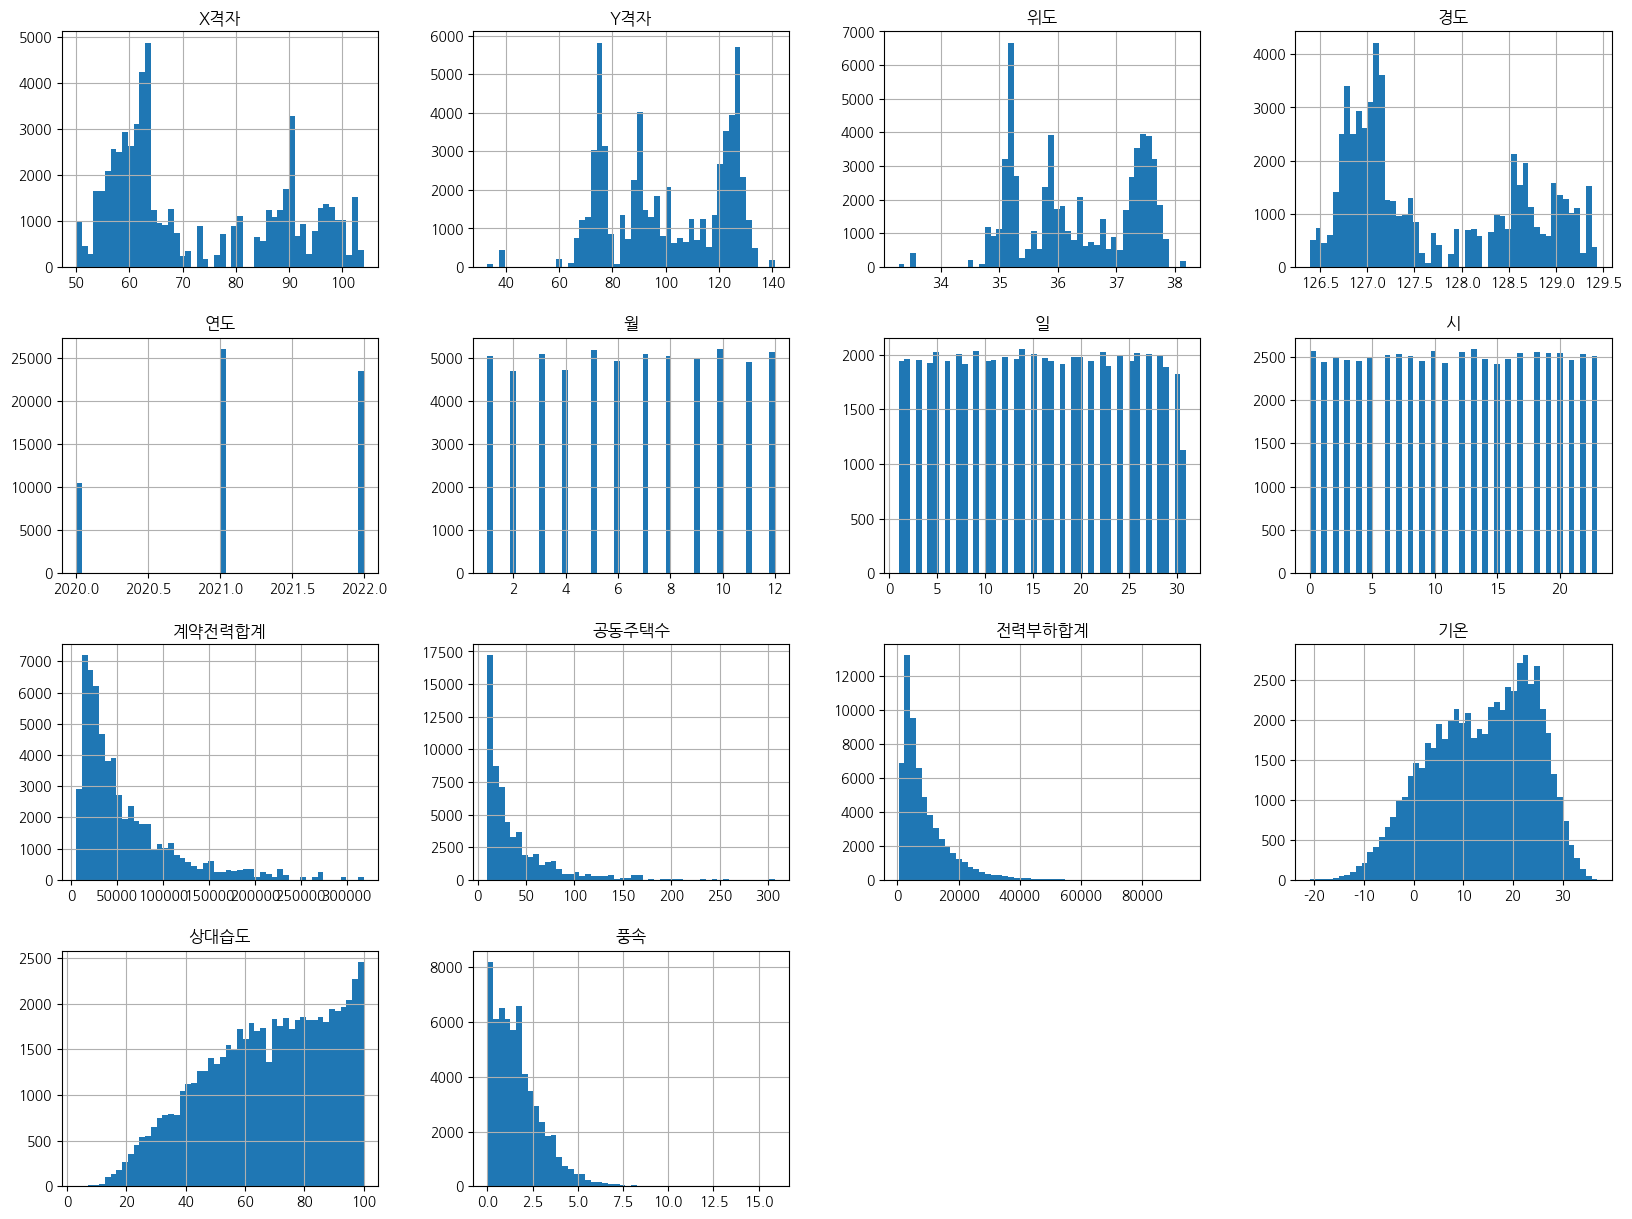

In [37]:
df_processed.hist(bins=50, figsize=(20, 15));

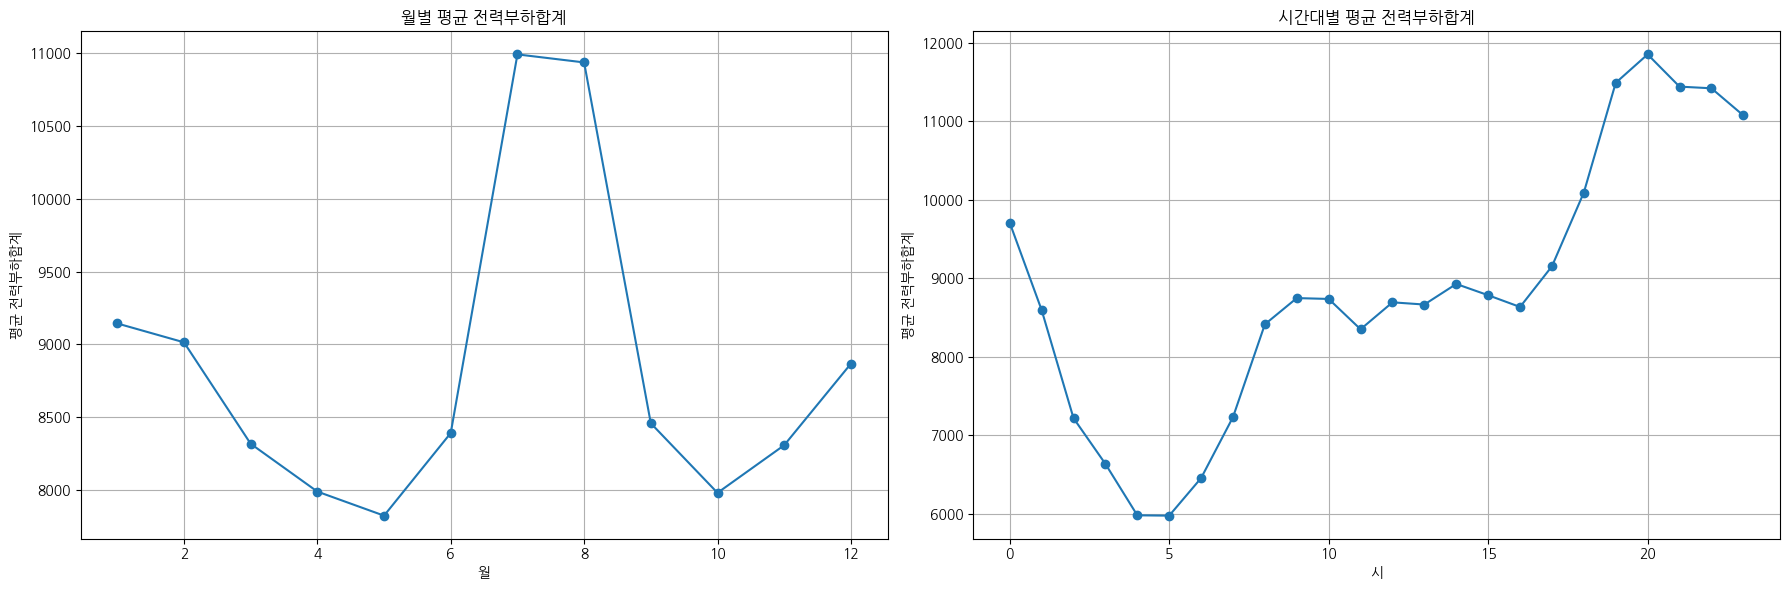

시간에 따른 전력부하 패턴 시각화


In [ ]:
# 시각화를 통해 데이터 패턴 파악 (분석 대상 연도 기준)
df_eda = df_processed.copy()
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
# 월별 평균 전력부하
df_eda.groupby(
    df_eda.index.month
    )['전력부하합계'].mean().plot(ax=axes[0], marker='o', title='월별 평균 전력부하합계')
axes[0].set_xlabel('월')
axes[0].set_ylabel('평균 전력부하합계')
axes[0].grid(True)
# 시간대별 평균 전력부하
df_eda.groupby(
    df_eda.index.hour
    )['전력부하합계'].mean().plot(ax=axes[1], marker='o', title='시간대별 평균 전력부하합계')
axes[1].set_xlabel('시')
axes[1].set_ylabel('평균 전력부하합계')
axes[1].grid(True)
plt.tight_layout()
plt.show()
print("시간에 따른 전력부하 패턴 시각화")

## 특성 공학

In [ ]:
# --- 특성 공학 (Feature Engineering) ---
print("\n--- 특성 공학 (Feature Engineering) ---")
# 분석 대상 연도 데이터만 필터링
df_target_year = df_processed[df_processed.index.year == YEAR_TO_ANALYZE].copy()

# 시간 관련 특성
df_target_year['월'] = df_target_year.index.month
df_target_year['시'] = df_target_year.index.hour
df_target_year['요일'] = df_target_year.index.dayofweek

# 주기성 특성 (Sin/Cos 변환)
df_target_year['시간_sin'] = np.sin(2 * np.pi * df_target_year['시'] / 24)
df_target_year['시간_cos'] = np.cos(2 * np.pi * df_target_year['시'] / 24)
df_target_year['월_sin'] = np.sin(2 * np.pi * df_target_year['월'] / 12)
df_target_year['월_cos'] = np.cos(2 * np.pi * df_target_year['월'] / 12)

# 파생 변수
df_target_year['주말'] = df_target_year['요일'].apply(lambda x: 1 if x >= 5 else 0)
df_target_year['냉방도일'] = np.maximum(0, df_target_year['기온'] - 24)
df_target_year['난방도일'] = np.maximum(0, df_target_year['기온'] - 18)
df_target_year['불쾌지수'] = 1.8 * df_target_year['기온'] - 0.55 * (1 - df_target_year['상대습도']/100) * (1.8 * df_target_year['기온'] - 26) + 32

# 시계열 특성 (Lag, Rolling)
for lag in [24, 168]: # 1일, 1주일 전 데이터
    df_target_year[f'전력부하_lag_{lag}h'] = df_target_year[TARGET_COLUMN].shift(lag)
    df_target_year[f'기온_lag_{lag}h'] = df_target_year['기온'].shift(lag)
df_target_year['기온_rolling_24h'] = df_target_year['기온'].rolling(window=24).mean()

# 특성 생성으로 인한 결측치는 이전 값으로 채움
df_target_year.fillna(method='bfill', inplace=True)
df_featured = df_target_year.copy()
print("특성 공학 완료. 최종 특성 개수:", len(df_featured.columns))


## 모델링 데이터 준비

In [ ]:
print("\n--- 모델링 데이터 준비 ---")
# 시계열 데이터를 훈련/테스트 세트로 분할
train = df_featured[df_featured.index < SPLIT_DATE]
test = df_featured[df_featured.index >= SPLIT_DATE]
print(f"훈련 데이터: {train.index.min()} ~ {train.index.max()} ({len(train)}개 행)")
print(f"테스트 데이터: {test.index.min()} ~ {test.index.max()} ({len(test)}개 행)")

# 특성(X)과 타겟(y) 분리
features = [col for col in df_featured.columns if col not in [
    TARGET_COLUMN, '연도', '월', '일', '시', '요일']]
X_train = train[features]
y_train = train[TARGET_COLUMN]
X_test = test[features]
y_test = test[TARGET_COLUMN]

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("데이터 분할 및 스케일링 완료.")

## 모델 훈련 및 평가 

In [ ]:
print("\n--- 모델 훈련 및 평가 ---")
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

results_list = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    
    results_list.append({'Model': name, 'R²': r2, 'RMSE': rmse, 'MAPE(%)': mape})
    
results_df = pd.DataFrame(results_list).set_index('Model')
print("모델별 성능 평가 결과:")
print(results_df.sort_values(by='R²', ascending=False))

## 최종 모델 분석 및 결과 시각화 

In [ ]:
print("\n--- 최종 모델 분석 및 결과 시각화 ---")
# 가장 성능이 좋았던 Random Forest를 최종 모델로 선정
final_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
final_model.fit(X_train_scaled, y_train)

# 특성 중요도 분석
importances = pd.Series(final_model.feature_importances_, index=features)
top_20_importances = importances.sort_values(ascending=False).head(20)
import seaborn as sns

# 특성 중요도 시각화 (seaborn)
plt.figure(figsize=(10, 7))
sns.barplot(
    y=top_20_importances.index,
    x=top_20_importances.values,
    orient='h',
    palette='viridis'
)
plt.title('상위 20개 특성 중요도 (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# 예측 결과 시각화 (seaborn)
y_pred_final = final_model.predict(X_test_scaled)
predictions = pd.DataFrame({'실제값': y_test, '예측값': y_pred_final}, index=y_test.index)

# 전체 테스트 기간 시각화 (seaborn)
plt.figure(figsize=(14, 5))
sns.lineplot(data=predictions[['실제값', '예측값']])
plt.title('테스트 기간 전체 예측 결과 (실제값 vs 예측값)')
plt.xlabel('날짜')
plt.ylabel('전력부하합계')
plt.tight_layout()
plt.show()

# 특정 1주일 확대 시각화 (seaborn)
sample_predictions = predictions.loc['2022-11-07':'2022-11-13']
plt.figure(figsize=(14, 5))
sns.lineplot(data=sample_predictions[['실제값', '예측값']], marker='o')
plt.title('테스트 기간 중 1주일 확대 (2022-11-07 ~ 2022-11-13)')
plt.xlabel('날짜 및 시간')
plt.ylabel('전력부하합계')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 결과 분석

In [ ]:
# --- 결론 ---
print("\n--- 결론 ---")
best_model = results_df.sort_values(by='R²', ascending=False).iloc[0]
print(f"분석 결과, {best_model.name} 모델이 R² 점수 {best_model['R²']:.2f}로 가장 높은 예측 성능을 보였습니다.")
print("주요 예측 변수로는 과거 전력부하(Lag), 계약전력합계, 기온 관련 특성 등이 확인되었습니다.")
print("모든 분석 과정이 완료되었습니다.")